# Caspase-3 and -7 Data analysis

initialize necessary packages

In [2]:
import os
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd

# import plotly.graph_objects as go
# import plotly.express as px
from scipy import stats
from Bio import SeqIO

import sequence_tools as st
import parse_dms_tools as dms
import parse_msa_tools as msa

from sklearn import preprocessing
import scipy.stats
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
standard_scaler = preprocessing.StandardScaler()
my_path = '/Users/hridindu/Documents/C3-C7_paper/PU'

### #reference sequences with subsequent coding start, coding terminus, n-terminus offset. ### 
c3 = 'caspase3_ref.fasta'
c7 = 'caspase7_ref.fasta'
(c3o, c3t, c3_off) = (149,926,28) ###Caspase-3 Open reading frame start, terminus, and numbering of 1st expressed amino acid
(c7o, c7t, c7_off) = (148,994,23) ###Caspase-7 Open reading frame start, terminus, and numbering of 1st expressed amino acid


/Users/hridindu/opt/anaconda3/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [3]:
### Parameters for creating figures

template = 'none'
import seaborn as sns; sns.set()
sns.set_style('white')
pal = sns.color_palette()
pal.as_hex()
c3_color = pal[0]
c7_color = pal[1]
params = {'axes.labelsize': 7,
          'axes.titlesize':7, 
          'legend.fontsize': 7, 
          'xtick.labelsize': 7, 
          'ytick.labelsize': 7}
matplotlib.rcParams.update(params)


Read the .csv outputs from the PU script and load into .pkl file

In [4]:
caspase_re = pickle.load(open('caspase_re.pkl', 'rb')) ### a relative entropy analysis that includes the aligned Caspase-3 and -7 positions. 

C3 = pd.read_csv('C3_agg.csv')
C3['Position_c3'] = C3['group'] + c3_off
C3['WT_aa'] = C3['Unnamed: 0'].str.slice(start = 0, stop = 1)
C3['mut'] = C3['Unnamed: 0'].apply(lambda x: x[-1])
C3 = C3.rename(columns = {'Unnamed: 0' : 'mutation'})
### Merge with caspase_re 
C3 = C3.merge(
                caspase_re[['Position_c3','Aligned Position', 'mean_RE_c3']], 
                left_on = 'Position_c3',
                right_on = 'Position_c3'
                )
C3 = C3.drop(labels = ['sep','group'], axis = 1)
C3['mutation'] = C3[['WT_aa', 'Position_c3', 'mut']].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)

In [5]:
C7 = pd.read_csv('C7_agg.csv')
C7['Position_c7'] = C7['group'] + c7_off
C7['WT_aa'] = C7['Unnamed: 0'].str.slice(start = 0, stop = 1)
C7['mut'] = C7['Unnamed: 0'].apply(lambda x: x[-1])
C7 = C7.rename(columns = {'Unnamed: 0' : 'mutation'})

C7 = C7.merge(
                    caspase_re[['Position_c7','Aligned Position', 'mean_RE_c7']], 
                    left_on = 'Position_c7',
                    right_on = 'Position_c7'
                    )
C7 = C7.drop(labels = ['sep','group'], axis = 1)
C7['mutation'] = C7[['WT_aa', 'Position_c7', 'mut']].apply(lambda row: ''.join(row.values.astype(str)), axis = 1)

In [ ]:
### write to .pkl file
pickle.dump(C3, open('C3.pkl', 'wb'))
pickle.dump(C7, open('C7.pkl', 'wb'))

Open MSA of Caspase-3 and -7 with calculated Relative Entropy, and convert them into pandas dataframes. 

In [6]:
### Align C3 and C7 data ###

c7_msa_re = pickle.load(open('/Users/hridindu/Documents/C3-C7_paper/PU/c7_msa_re.pkl', 'rb'))
c7_msa_re = c7_msa_re[['re_flat', 'pct_re', 'Position']]

aln = list(SeqIO.parse('c3_c7_aln.fasta', 'fasta'))

c3_aln = {
        'WT' : [aa for pos, aa in enumerate(aln[1].seq + '*', 1) if aa != '-'],
        'aln_pos' : [pos for pos, aa in enumerate(aln[1].seq + '*', 1) if aa != '-'],
        'gene': [aln[1].id for pos, aa in enumerate(aln[1].seq + '*', 1) if aa != '-']
            }
c7_aln = {
        'WT' : [aa for pos, aa in enumerate(aln[0].seq + '*' , 1) if aa != '-'],
        'aln_pos' : [pos for pos, aa in enumerate(aln[0].seq + '*' , 1) if aa != '-'],
        'gene': [aln[0].id for pos, aa in enumerate(aln[0].seq + '*', 1) if aa != '-']
            }
c3_aln = pd.DataFrame(data = c3_aln, dtype = 'float')
c7_aln = pd.DataFrame(data = c7_aln, dtype = 'float')

/var/folders/rm/d65b6jpd0hl_1ttyvkq6frgc0000gn/T/ipykernel_9830/2552780656.py:18: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  c3_aln = pd.DataFrame(data = c3_aln, dtype = 'float')
/var/folders/rm/d65b6jpd0hl_1ttyvkq6frgc0000gn/T/ipykernel_9830/2552780656.py:19: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  c7_aln = pd.DataFrame(data = c7_aln, dtype = 'float')


Calculate mean absolute value of LASSO coefficients for each position on Casapse-3 and -7

In [7]:
c_mean = pd.merge(C3, C7, how = 'outer',  on = 'Aligned Position', suffixes= ('_c3', '_c7'))

In [8]:
### Take mean of abs of coef ###

mean_abs_coef_c7 = c_mean[['coef_c7', 
                           'Position_c7', 
                           'WT_aa_c7', 
                           'Aligned Position', 
                           'mean_RE_c7',
                           'p_c7']].groupby(['Position_c7', 'WT_aa_c7', 'Aligned Position','mean_RE_c7']).apply(lambda x: x.abs().mean()).reset_index()

mean_abs_coef_c3 = c_mean[['coef_c3', 
                            'Position_c3', 
                            'WT_aa_c3', 
                            'Aligned Position',
                            'mean_RE_c3',
                            'p_c3']].groupby(['Position_c3', 'WT_aa_c3', 'Aligned Position','mean_RE_c3']).apply(lambda x: x.abs().mean()).reset_index()


Calculate divergence in coefficients at each position between Caspase -3 and -7, and standardize

In [9]:
### Merge dataframes
c_coef_div = mean_abs_coef_c3.merge(mean_abs_coef_c7, on = 'Aligned Position')
### Standardize coefficients
c_coef_div[['coef_c3','coef_c7']] = standard_scaler.fit_transform(c_coef_div[['coef_c3','coef_c7']])
### Subtract C7 from C3
c_coef_div['div'] = c_coef_div['coef_c3'] - c_coef_div['coef_c7']
### Normalize from 0 to 100 for PDB mapping
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1e-6, 100))
c_coef_div['norm_div'] = min_max_scaler.fit_transform(c_coef_div[['div']])

Plot the rolling average of percentile-ranked coefficients for Caspase -3 and -7 compared to the analogous Relative Entropy in the MSA

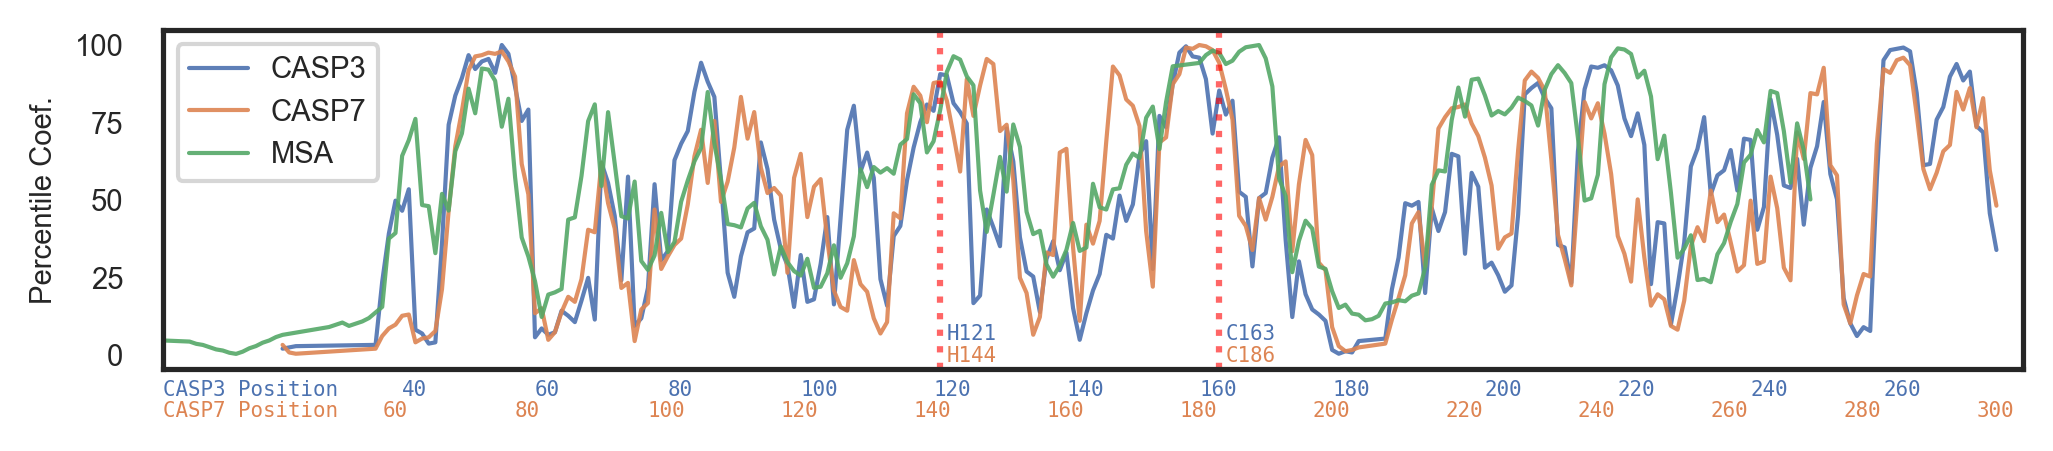

In [14]:

dim = (8, 1.5)
fig, ax = plt.subplots(figsize=dim,
                       dpi = 300)
x = c_coef_div['Aligned Position']
y1 = c_coef_div['mean_RE_c3'].rolling(5).mean().rank(pct=True)*100
y2 = c_coef_div['mean_RE_c7'].rolling(5).mean().rank(pct=True)*100
x3 = c7_msa_re['Position']
y3 = c7_msa_re['re_flat'].rolling(5).mean().rank(pct=True)*100

sns.lineplot(
             x = x,
             y = y1,  
             label = 'CASP3',
             color = '#4c71b0',
             alpha = 0.9,
             linewidth = 1,
            )
sns.lineplot(
             x = x,
             y = y2,  
             label = 'CASP7',
             color = '#dd8452',
             alpha = 0.9,
             linewidth = 1,
            )
sns.lineplot(
             x = x - 28,
             y = y3,  
             label = 'MSA',
             color = '#54a867',
             alpha = 0.9,
             linewidth = 1,
            )
plt.axvline(x=122, color = 'red', alpha = 0.6, linestyle = ':')
plt.axvline(x=164, color = 'red', alpha = 0.6, linestyle = ':')
# plt.axvline(x=176, color = 'red', alpha = 0.6, linestyle = ':')
plt.xlim(5,285)

#plt.ylabel('Percentile RE')
plt.ylabel("""Percentile Coef.""")
plt.xlabel("""""")
plt.legend(loc = 'upper left')
ax.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)


c7_seq = list(zip(c_coef_div['WT_aa_c7'], c_coef_div['Aligned Position'], c_coef_div['Position_c7']))
c3_seq = list(zip(c_coef_div['WT_aa_c3'], c_coef_div['Aligned Position'], c_coef_div['Position_c3']))
for aa,al_pos,wt_pos in c7_seq:
    if wt_pos % 20 == 0:
        plt.text(al_pos,-20,int(wt_pos), fontdict = {'family' : 'monospace',
                                                     'size'   : '5',
                                                     'color'  : c7_color})
    if al_pos == 164:
        plt.text(al_pos+1,-2,"C"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                                                 'size'   : '5',
                                                                 'color'  : c7_color})
    if al_pos == 122:
        plt.text(al_pos+1,-2,"H"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                                                 'size'   : '5',
                                                                 'color'  : c7_color})
#     if al_pos == 176:
#         plt.text(al_pos+1,87,"D"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
#                                              'size'   : '5',
#                                              'color'  : c7_color})
for aa,al_pos,wt_pos in c3_seq:
    if wt_pos % 20 == 0:
        plt.text(al_pos,-13,int(wt_pos), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
    if al_pos == 164:
        plt.text(al_pos+1,5,"C"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
    if al_pos == 122:
        plt.text(al_pos+1,5,"H"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
#     if al_pos == 176:
#         plt.text(al_pos+1,95,"D"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
#                                              'size'   : '5',
#                                              'color'  : c3_color})
plt.text(5,-13,'''CASP3 Position''', fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
plt.text(5,-20,'''CASP7 Position''', fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c7_color})
# plt.savefig('c_re_rolling.svg',  dpi = 600, transparent = True)
plt.show()
plt.close()

Text(7, -3.4, 'CASP7 Position')

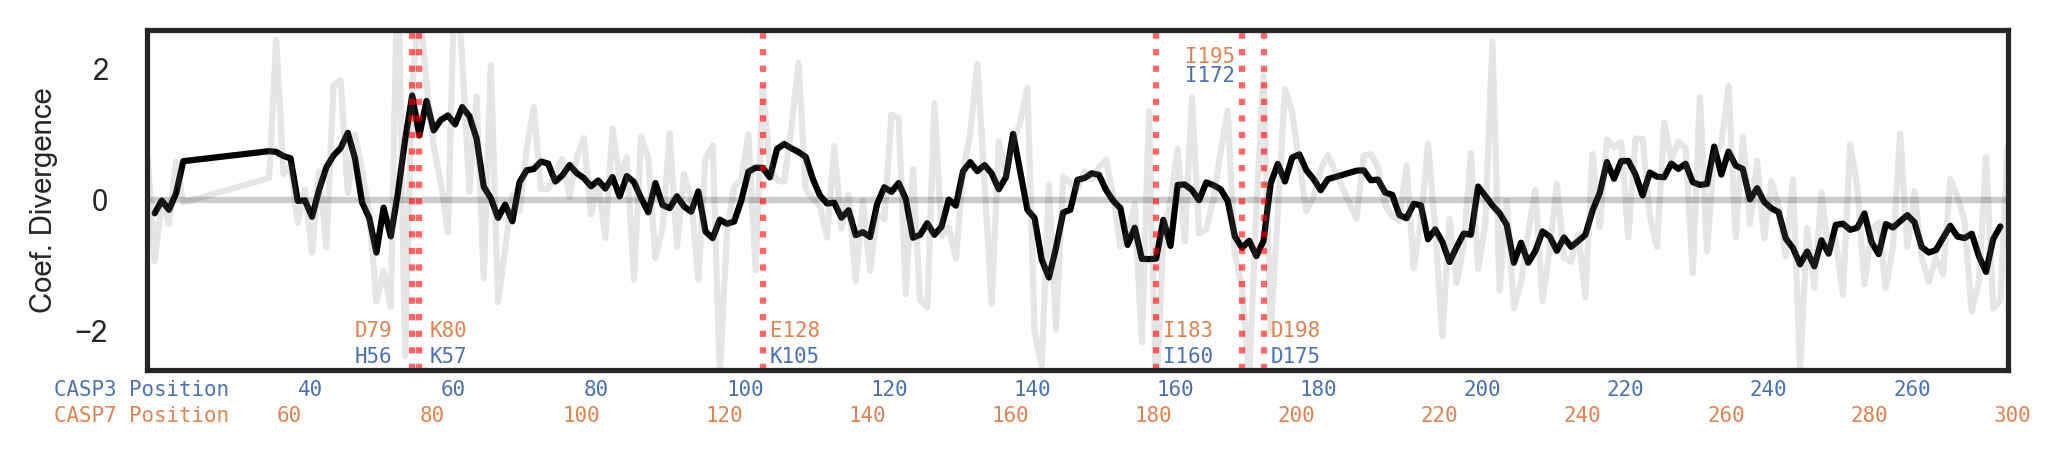

In [14]:
fontdict7 = {'family' : 'monospace',
            'size'   : '5',
            'color'  : c7_color}
fontdict3 = {'family' : 'monospace',
            'size'   : '5',
            'color'  : c3_color}

x = c_coef_div['Aligned Position']
y = c_coef_div['div']
y_rolling = y.rolling(5, center = True).mean()

dim = (8,1.5)
fig, ax = plt.subplots(figsize=dim,
                       dpi = 300)


ax = sns.lineplot(x=x,y=y_rolling, color = 'black')
ax = sns.lineplot(x=x,y=y, alpha = 0.2, color = 'grey')
ax = sns.lineplot(x=x, y = 0, color = 'black', alpha = 0.2)
ax.set_xlabel('Aligned Caspase Position')
ax.set_ylabel('Coef. Divergence')
plt.xlim(20,280)
plt.ylim(-2.6,2.6)
ax.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)
plt.xlabel("""""")


for aa,al_pos,wt_pos in c7_seq:
    if wt_pos % 20 == 0:
        plt.text(al_pos,-3.4,int(wt_pos), fontdict = fontdict7)
    if al_pos == 161:
        plt.text(al_pos+1,-2.1,aa+str(int(wt_pos)), fontdict = fontdict7)
    if al_pos == 173:
        plt.text(al_pos-8,2.1,aa+str(int(wt_pos)), fontdict = fontdict7)
    if al_pos == 176:
        plt.text(al_pos+1,-2.1,aa+str(int(wt_pos)), fontdict = fontdict7)
    if al_pos == 57:
        plt.text(al_pos-8,-2.1,aa+str(int(wt_pos)), fontdict = fontdict7)
    if al_pos == 58:
        plt.text(al_pos+1.5,-2.1,aa+str(int(wt_pos)), fontdict = fontdict7)
    if al_pos == 106:
        plt.text(al_pos+1,-2.1,aa+str(int(wt_pos)), fontdict = fontdict7)
    
for aa,al_pos,wt_pos in c3_seq:
    if wt_pos % 20 == 0:
        plt.text(al_pos,-3,int(wt_pos), fontdict = fontdict3)
    if al_pos == 161:
        plt.text(al_pos+1,-2.5,aa+str(int(wt_pos)), fontdict = fontdict3)
        plt.axvline(x=al_pos, color = 'red', alpha = 0.6, linestyle = ':')
    if al_pos == 173:
        plt.text(al_pos-8,1.8,aa+str(int(wt_pos)), fontdict = fontdict3)
        plt.axvline(x=al_pos, color = 'red', alpha = 0.6, linestyle = ':')

    if al_pos == 176:
        plt.text(al_pos+1,-2.5,aa+str(int(wt_pos)), fontdict = fontdict3)
        plt.axvline(x=al_pos, color = 'red', alpha = 0.6, linestyle = ':')
    if al_pos == 57:
        plt.text(al_pos-8,-2.5,aa+str(int(wt_pos)), fontdict = fontdict3)
        plt.axvline(x=al_pos, color = 'red', alpha = 0.6, linestyle = ':')
    if al_pos == 58:
        plt.text(al_pos+1.5,-2.5,aa+str(int(wt_pos)), fontdict = fontdict3)
        plt.axvline(x=al_pos, color = 'red', alpha = 0.6, linestyle = ':')
    if al_pos == 106:
        plt.text(al_pos+1,-2.5,aa+str(int(wt_pos)), fontdict = fontdict3)
        plt.axvline(x=al_pos, color = 'red', alpha = 0.6, linestyle = ':')

plt.text(7,-3,'''CASP3 Position''', fontdict = fontdict3)
plt.text(7,-3.4,'''CASP7 Position''', fontdict = fontdict7)

    
# plt.savefig('c_coef_pos_div.svg', 
#              transparent = True, 
#              dpi = 300)

Plot heatmaps of coefficients 

In [15]:
hm_c3 = pd.pivot_table(C3, values = 'coef', columns = 'mut', index = 'Aligned Position').fillna(0).drop(columns = "*")
hm_c7 = pd.pivot_table(C7, values = 'coef', columns = 'mut', index = 'Aligned Position').fillna(0).drop(columns = "*")
hm_c3.index = hm_c3.index.astype(int)
hm_c7.index = hm_c7.index.astype(int)
hm_div = hm_c3.sub(hm_c7, axis = 'rows')
hm_div = hm_div.fillna(0)

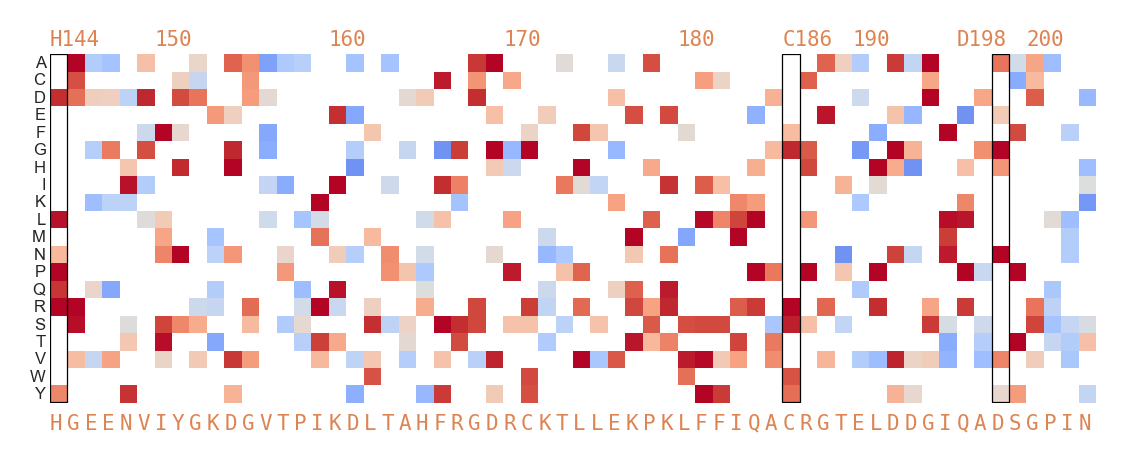

In [16]:
dim = (4.5,2)
fig2, ax2 = plt.subplots(
                        figsize=dim,
                        dpi = 300)
data = hm_c7[18:].T.replace(0,np.nan)
sns.heatmap(data = data,
                   square = True,
                   cbar = False,
                   center = 0,
                   cmap = "coolwarm_r",
                   ax=ax2,
                   xticklabels=20,
                   yticklabels = 1,
                   vmin = -1.5,
                   vmax = 1,
                )
ax2.set_facecolor('white')

plt.xlim(120-18,180-18)
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=0)
ax2.tick_params(axis='y', labelsize= 4, pad=-5)
ax2.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)
    
c7_seq = list(zip(c_coef_div['WT_aa_c7'], c_coef_div['Aligned Position'], c_coef_div['Position_c7']))
for aa,al_pos,wt_pos in c7_seq[120-28:180-28]:
    plt.text(al_pos-20,21.5,aa, fontdict = {'family' : 'monospace',
                                         'size'   : '5',
                                         'color'  : c7_color})
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c7_color})
    if al_pos == 164:
        plt.text(al_pos-20,-.5,"C"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c7_color})
    if al_pos == 122:
        plt.text(al_pos-20,-.5,"H"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c7_color})
    if al_pos == 176:
        plt.text(al_pos-22,-.5,"D"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c7_color})        
ax2.add_patch(Rectangle((122-20, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))
ax2.add_patch(Rectangle((164-20, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))
ax2.add_patch(Rectangle((176-20, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))

# plt.savefig('c7_active_site_hm_horizantal.svg', dpi = 300, transparent = True )

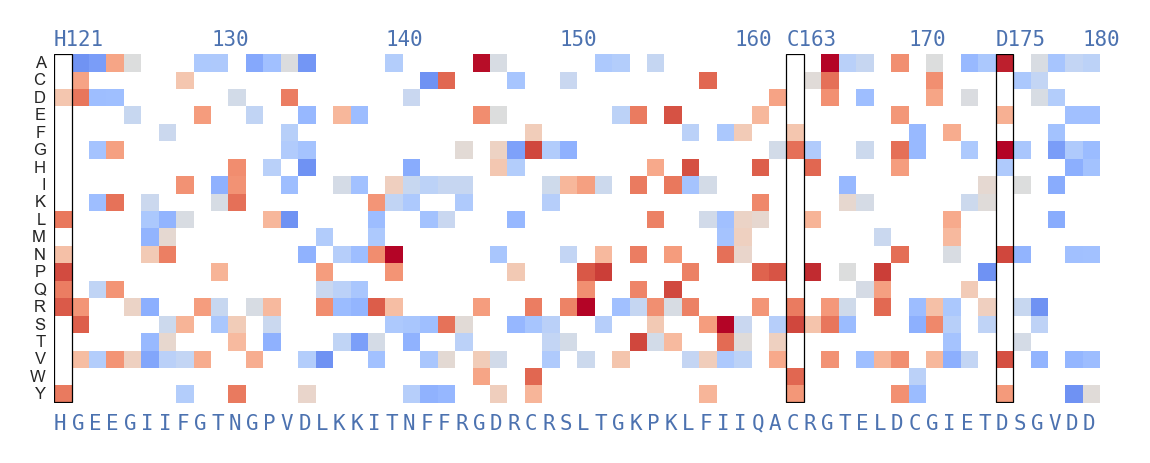

In [17]:
dim = (4.5,1.8)
fig2, ax2 = plt.subplots(
                        figsize=dim,
                       dpi = 300)
data = hm_c3.T.replace(0,np.nan)
sns.heatmap(data = data,
                   square = True,
                   cbar = False,
                   center = 0,
                   cmap = "coolwarm_r",
                   ax=ax2,
                   xticklabels=20,
                   yticklabels = 1,
                   vmin = -1.5,
                   vmax = 1,
                )
ax2.set_facecolor('white')
plt.xlim(120-28,180-28)
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=0)
ax2.tick_params(axis='y', labelsize= 4, pad=-4)
ax2.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)


c3_seq = list(zip(c_coef_div['WT_aa_c3'], c_coef_div['Aligned Position'], c_coef_div['Position_c3']))
for aa,al_pos,wt_pos in c3_seq[120-28:180-28]:
    plt.text(al_pos-30,21.5,aa, fontdict = {'family' : 'monospace',
                                         'size'   : '5',
                                         'color'  : c3_color})
    if wt_pos % 10 == 0:
        plt.text(al_pos-30,-.5,int(wt_pos), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
    if al_pos == 164:
        plt.text(al_pos-30,-.5,"C"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
    if al_pos == 122:
        plt.text(al_pos-30,-.5,"H"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color})
    if al_pos == 176:
        plt.text(al_pos-30,-.5,"D"+str(int(wt_pos)), fontdict = {'family' : 'monospace',
                                             'size'   : '5',
                                             'color'  : c3_color}) 
        
ax2.add_patch(Rectangle((122-30, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))
ax2.add_patch(Rectangle((164-30, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))
ax2.add_patch(Rectangle((176-30, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))


# plt.savefig('c3_active_site_hm_horizantal.svg', dpi = 300, transparent = True )


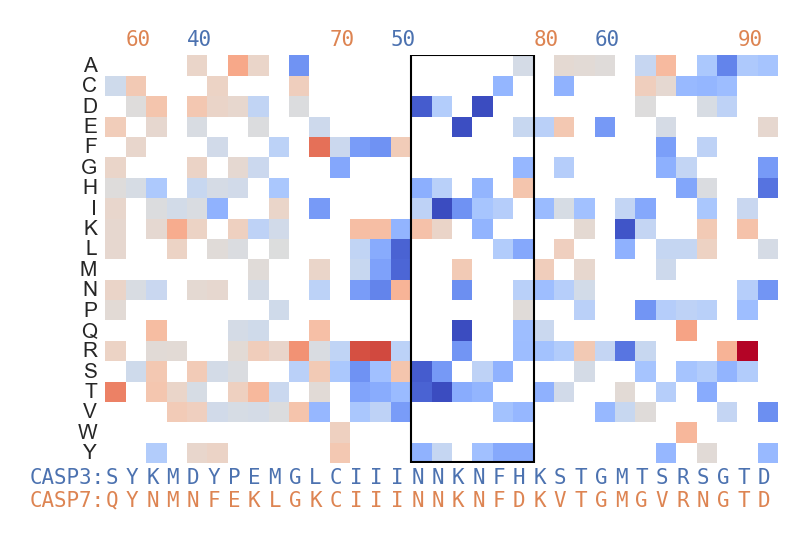

In [18]:
dim = (4,1.8)
fig2, ax2 = plt.subplots(
                        figsize=dim,
                       dpi = 300)
data = hm_div[hm_div.index >= 20].T.replace(0,np.nan)
lim1 = 17
lim2 = 50
sns.heatmap(data = data,
                   square = True,
                   cbar = False,
                   center = 0,
                   cmap = "coolwarm_r",
                   ax=ax2,
                   xticklabels=10,
                   yticklabels = 1,
                   vmin = -2.25,
                   vmax = 2.25,
                )
ax2.set_facecolor('white')
plt.xlim(lim1,lim2)
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=0)
ax2.tick_params(axis='y', labelsize= 5, pad=-4)
ax2.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)


c3_seq = list(zip(c_coef_div['WT_aa_c3'], c_coef_div['Aligned Position'], c_coef_div['Position_c3']))
for aa,al_pos,wt_pos in c3_seq[lim1-10:lim2-10]:
    plt.text(al_pos-20,21,aa, fontdict = fontdict3)
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = fontdict3)
    
c7_seq = list(zip(c_coef_div['WT_aa_c7'], c_coef_div['Aligned Position'], c_coef_div['Position_c7']))
for aa,al_pos,wt_pos in c7_seq[lim1-10:lim2-10]:
    plt.text(al_pos-20,22.1,aa, fontdict = fontdict7)
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = fontdict7)
        
plt.text(lim1-3.7,21,'''CASP3:''', fontdict = fontdict3)
plt.text(lim1-3.7,22.1,'''CASP7:''', fontdict = fontdict7)

ax2.add_patch(Rectangle((52-20, 0), 6, 19.95, fill=False, edgecolor='black', lw=.5))
# ax2.add_patch(Rectangle((164-30, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))
# ax2.add_patch(Rectangle((176-30, 0), 1, 19.95, fill=False, edgecolor='black', lw=.3))

# plt.savefig('coef_div_hm_nnk.svg', dpi = 300, transparent = True )
plt.show()
plt.close()

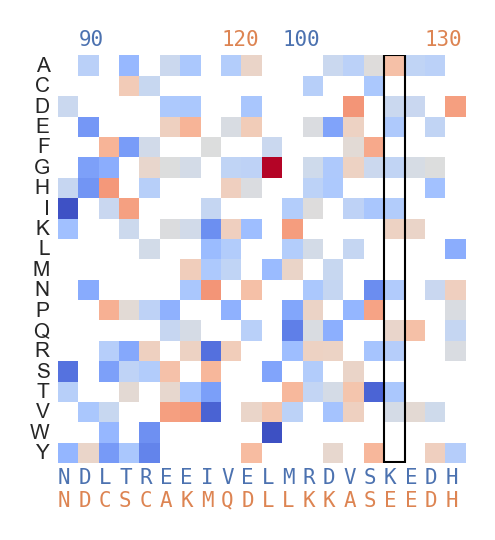

In [19]:
dim = (4,1.8)
fig2, ax2 = plt.subplots(
                        figsize=dim,
                       dpi = 300)
data = hm_div[hm_div.index >= 20].T.replace(0,np.nan)
lim1 = 70
lim2 = 90
sns.heatmap(data = data,
                   square = True,
                   cbar = False,
                   center = 0,
                   cmap = "coolwarm_r",
                   ax=ax2,
                   xticklabels=10,
                   yticklabels = 1,
                   vmin = -2.25,
                   vmax = 2.25,
                )
ax2.set_facecolor('white')
plt.xlim(lim1,lim2)
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=0)
ax2.tick_params(axis='y', labelsize= 5, pad=-4)
ax2.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)


c3_seq = list(zip(c_coef_div['WT_aa_c3'], c_coef_div['Aligned Position'], c_coef_div['Position_c3']))
for aa,al_pos,wt_pos in c3_seq[lim1-10:lim2-10]:
    plt.text(al_pos-20,21,aa, fontdict = fontdict3)
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = fontdict3)
    
c7_seq = list(zip(c_coef_div['WT_aa_c7'], c_coef_div['Aligned Position'], c_coef_div['Position_c7']))
for aa,al_pos,wt_pos in c7_seq[lim1-10:lim2-10]:
    plt.text(al_pos-20,22.1,aa, fontdict = fontdict7)
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = fontdict7)
        
# plt.text(lim1-3.7,21,'''CASP3:''', fontdict = fontdict3)
# plt.text(lim1-3.7,22.1,'''CASP7:''', fontdict = fontdict7)
ax2.add_patch(Rectangle((106-20, 0), 1, 19.95, fill=False, edgecolor='black', lw=.5))


# plt.savefig('coef_div_hm_k105.svg', dpi = 300, transparent = True )
plt.show()
plt.close()

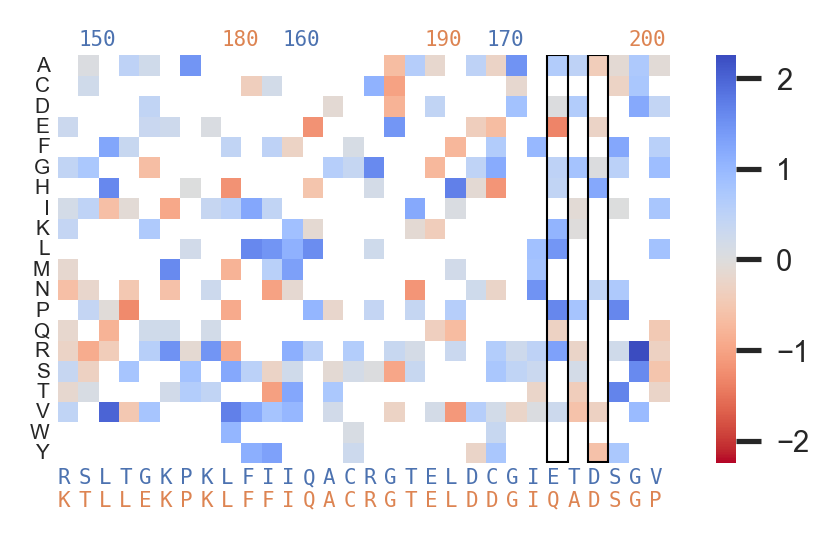

In [20]:
dim = (4,1.8)
fig2, ax2 = plt.subplots(
                        figsize=dim,
                       dpi = 300)
data = hm_div[hm_div.index >= 20].T.replace(0,np.nan)
lim1 = 150-20
lim2 = 180-20
sns.heatmap(data = data,
                   square = True,
                   cbar = True,
                   center = 0,
                   cmap = "coolwarm_r",
                   ax=ax2,
                   xticklabels=10,
                   yticklabels = 1,
                   vmin = -2.25,
                   vmax = 2.25,
                )
ax2.set_facecolor('white')
plt.xlim(lim1,lim2)
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=0)
ax2.tick_params(axis='y', labelsize= 5, pad=-4)
ax2.tick_params(axis='x', labelsize= 5, pad=-5, labeltop= False, labelbottom=False)


c3_seq = list(zip(c_coef_div['WT_aa_c3'], c_coef_div['Aligned Position'], c_coef_div['Position_c3']))
for aa,al_pos,wt_pos in c3_seq[lim1-10:lim2-10]:
    plt.text(al_pos-20,21,aa, fontdict = fontdict3)
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = fontdict3)
    
c7_seq = list(zip(c_coef_div['WT_aa_c7'], c_coef_div['Aligned Position'], c_coef_div['Position_c7']))
for aa,al_pos,wt_pos in c7_seq[lim1-10:lim2-10]:
    plt.text(al_pos-20,22.1,aa, fontdict = fontdict7)
    if wt_pos % 10 == 0:
        plt.text(al_pos-20,-.5,int(wt_pos), fontdict = fontdict7)
        
# plt.text(lim1-3.7,21,'''CASP3:''', fontdict = fontdict3)
# plt.text(lim1-3.7,22.1,'''CASP7:''', fontdict = fontdict7)
ax2.add_patch(Rectangle((176-20, 0), 1, 19.95, fill=False, edgecolor='black', lw=.5))
ax2.add_patch(Rectangle((174-20, 0), 1, 19.95, fill=False, edgecolor='black', lw=.5))

# plt.savefig('coef_div_hm_d175.svg', dpi = 300, transparent = True )
plt.show()
plt.close()